     |████████████████████████████████| 161 kB 2.2 MB/s eta 0:00:01    |████████████████▎               | 81 kB 1.9 MB/s eta 0:00:01
  Using cached ipython-3.2.3-py3-none-any.whl (3.4 MB)
  Using cached jupyter_pip-0.3.1-py3-none-any.whl
  Using cached gnureadline-8.1.2-cp38-cp38-macosx_10_9_x86_64.whl (155 kB)
  Created wheel for nb-mermaid: filename=nb_mermaid-0.1.0-py3-none-any.whl size=163197 sha256=15523e02f3a38f61aa121d97e794402b3ea82b7cbeecc0ea118ffe79f3932027
  Stored in directory: /Users/andra/Library/Caches/pip/wheels/10/e3/44/b308bd8a7b4f153e80425515bf8831d4828175e540413c0b3b
Successfully built nb-mermaid
  Attempting uninstall: IPython
    Found existing installation: ipython 8.2.0
    Uninstalling ipython-8.2.0:
      Successfully uninstalled ipython-8.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipywidgets 7.7.0 requires ipython>=4.0.0; pyt

In [2]:
%reload_ext mermaid

<IPython.core.display.Javascript object>

In [3]:
%%javascript
import notebook
notebook.nbextensions.check_nbextension('nb-mermaid',user=True)
require(['base/js/utils'],
function(utils) {
        utils.load_extensions('nb-mermaid/nb-mermaid');
});

<IPython.core.display.Javascript object>

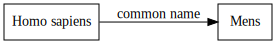

In [13]:
import graphviz
from wikidataintegrator import wdi_core
schema = graphviz.Digraph("test", filename='test.gv')
schema.graph_attr['rankdir'] = 'LR'

schema.attr('node', shape="rectangle")
schema.node('homo_sapiens', label='Homo sapiens')
schema.node('mens', label='Mens')
schema.edge('homo_sapiens', 'mens', label="common name")
schema

In [91]:
#names = "Amanita muscaria"

def extract_wikidata_taxonomic_record(name, language="en"):
    query = f"""
     SELECT DISTINCT ?schema ?subject ?subjectLabel ?object ?objectLabel (GROUP_CONCAT(DISTINCT ?object_wikifamily) as ?objectwikis) (GROUP_CONCAT(DISTINCT ?subject_wikifamily) as ?subjectwikis) WHERE {{
       SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
       VALUES ?taxon_name {{"{names}"}}
       # VALUES ?object_wikifamily {{<https://en.wikipedia.org/>}}
       # VALUES ?subject_wikifamily {{<https://en.wikipedia.org/>}}
        {{
        ## A wikipedia article that is linked through a different item that is labeled as
        ## instance of (P31) organisms known by a particular common name (Q55983715). The link
        ## with the given taxon name is through qualifier of (P642).
        BIND ("organisms known by a particular common name (e:E382)" as ?schema)
        BIND (?aka_item as ?subject)
        BIND (?item as ?object)

        optional {{?subject_article schema:about ?subject ;
                                    schema:isPartOf ?subject_wikifamily .}}
        optional {{?object_article schema:about ?object ;
                                    schema:isPartOf ?object_wikifamily .}}

        ?item wdt:P225 ?taxon_name .
        ?aka_item p:P31 [
             ps:P31 wd:Q55983715 ;
             pq:P642 ?item ;
          ] .
        optional {{?subject_article schema:about ?subject ;
                                    schema:isPartOf ?subject_wikifamily .}}
        optional {{?object_article schema:about ?object ;
                                    schema:isPartOf ?object_wikifamily .}}
        }}

        UNION

        {{
            ## A wikipedia article that is linked through a basionym
            BIND ("basionym (e:E384)" as ?schema)
            BIND (?item as ?subject)
            BIND (?basionym as ?object)
            ?item wdt:P566 ?basionym ;
                  wdt:P225 ?taxon_name .
                optional {{?subject_article schema:about ?subject ;
                                    schema:isPartOf ?subject_wikifamily .}}
        optional {{?object_article schema:about ?object ;
                                    schema:isPartOf ?object_wikifamily .}}
        }}

        UNION

        {{
            ## A wikipedia article that is linked through a taxonomic synonym
            BIND ("taxon synonym 1 (e:E385)" as ?schema)
            BIND (?item as ?subject)
            BIND (?synonym as ?object)
            ?item wdt:P1420 ?synonym ;
                  wdt:P225 ?taxon_name .
                optional {{?subject_article schema:about ?subject ;
                                    schema:isPartOf ?subject_wikifamily .}}
        optional {{?object_article schema:about ?object ;
                                    schema:isPartOf ?object_wikifamily .}}
        }}

        UNION

        {{
          ## A Wikipedia article that is linked through a synonym, this is different from
          ## the above one where the taxon synonym is through a property taxon synonym
          ## here it is through a P31 (instance of) synonym.
            BIND ("taxon synonym 2 (e:E386)" as ?schema)
            BIND (?synonym_item as ?subject)
            BIND (?item as ?object)
           ?item wdt:P225 ?taxon_name .
           ?synonym_item p:P31 [
              ps:P31 wd:Q1040689 ;
              pq:P642 ?item
           ]
               optional {{?subject_article schema:about ?subject ;
                                    schema:isPartOf ?subject_wikifamily .}}
        optional {{?object_article schema:about ?object ;
                                    schema:isPartOf ?object_wikifamily .}}
        }}

        UNION

        {{
            ## a wikipedia article that is linked through its protonym
            BIND ("protonym (e:E387)" as ?schema)
            BIND (?protonym_item as ?subject)
            BIND (?item as ?object)
          ?item wdt:P225 ?taxon_name .
          ?protonym_item p:P2868 [
                       ps:P2868 wd:Q10640897 ; # has role protonym
                       pq:P642 ?item ;
                 ] .
                optional {{?subject_article schema:about ?subject ;
                                    schema:isPartOf ?subject_wikifamily .}}
        optional {{?object_article schema:about ?object ;
                                    schema:isPartOf ?object_wikifamily .}}
        }}

        UNION

        {{
          ## a wikipedia article that is linked through a property said to be the same as (P460)
          BIND ("said to be the same (e:E388)" as ?schema)
          BIND (?wikidata_item as ?subject)
          BIND (?item as ?object)
          ?item wdt:P225 ?taxon_name .
          ?wikidata_item wdt:P460 ?item .
              optional {{?subject_article schema:about ?subject ;
                                    schema:isPartOf ?subject_wikifamily .}}
        optional {{?object_article schema:about ?object ;
                                    schema:isPartOf ?object_wikifamily .}}
    }}
    }} GROUP BY ?schema ?subject ?subjectLabel ?object ?objectLabel
    """
    edgesdrawn = []
    df = wdi_core.WDFunctionsEngine.execute_sparql_query(query, as_dataframe=True)
    schema = graphviz.Digraph("test", filename='test.gv')
    schema.graph_attr['label'] = names
    schema.graph_attr['rankdir'] = 'LR'
    schema.attr('node', shape="rectangle")
    nodes = []
    for index, row in df.iterrows():
        subjectnode = str(row["subject"]).replace("http://www.wikidata.org/entity/", "")
        if subjectnode not in nodes:
            nodes.append(subjectnode)
            schema.node(subjectnode, label=row["subjectLabel"]+' (wd:'+subjectnode+")")

        objectnode = str(row["object"]).replace("http://www.wikidata.org/entity/", "")
        if objectnode not in nodes:
            nodes.append(objectnode)
            schema.node(objectnode, label=row["objectLabel"]+' (wd:'+row["object"].replace("http://www.wikidata.org/entity/", "")+")")

        if f"https://{language}.wikipedia.org/" in row["subjectwikis"].split():
            if subjectnode+nodename not in edgesdrawn:
                nodename = f"{language}.wiki"
                schema.node(nodename)
                schema.edge(subjectnode, nodename, label="schema:isPartOf")
                edgesdrawn.append(subjectnode+nodename)
        if f"https://{language}.wikipedia.org/" in row["objectwikis"].split():
             if objectnode+nodename not in edgesdrawn:
                schema.node(nodename)
                schema.edge(objectnode, nodename, label="schema:isPartOf")    
                edgesdrawn.append(objectnode+nodename)
        schema.edge(subjectnode, objectnode, label=row["schema"])
        return schema
schema = extract_wikidata_taxonomic_record("Mnium hornum")
schema.view()

'test.gv.pdf'

In [83]:
for index, row in df.iterrows():
    subjectnode = row["subject"].replace("http://www.wikidata.org/entity/", "")
    if subjectnode not in nodes:
        nodes.append(subjectnode)
        schema.node(row["subject"].replace("http://www.wikidata.org/entity/", ""), label=subjectLabel+' (wd:'+row["subject"].replace("http://www.wikidata.org/entity/", "")+")")
    objectnode = row["object"].replace("http://www.wikidata.org/entity/", "")
    if objectnode not in nodes:
        nodes.append(objectnode)
        schema.node(row["object"].replace("http://www.wikidata.org/entity/", ""), label=objectLabel+' (wd:'+row["object"].replace("http://www.wikidata.org/entity/", "")+")")
    schema.edge(subjectLabel+' (wd:'+row["subject"].replace("http://www.wikidata.org/entity/", "")+")", 
               objectLabel+' (wd:'+row["object"].replace("http://www.wikidata.org/entity/", "")+")", label=schema)
schema

NameError: name 'subjectLabel' is not defined

In [75]:
df

,schema,subject,subjectLabel,object,objectLabel,objectwikis,subjectwikis
0,taxon synonym 1 (e:E385),http://www.wikidata.org/entity/Q131227,Amanita muscaria,http://www.wikidata.org/entity/Q108545401,Amanita muscaria subsp. flavivolvata,,https://jv.wikipedia.org/ https://an.wikipedia...
1,basionym (e:E384),http://www.wikidata.org/entity/Q131227,Amanita muscaria,http://www.wikidata.org/entity/Q21870095,Agaricus muscarius,https://pnb.wikipedia.org/ https://ur.wikipedi...,https://jv.wikipedia.org/ https://an.wikipedia...
2,taxon synonym 1 (e:E385),http://www.wikidata.org/entity/Q131227,Amanita muscaria,http://www.wikidata.org/entity/Q21870095,Agaricus muscarius,https://pnb.wikipedia.org/ https://ur.wikipedi...,https://af.wikipedia.org/ https://ar.wikipedia...
3,taxon synonym 1 (e:E385),http://www.wikidata.org/entity/Q131227,Amanita muscaria,http://www.wikidata.org/entity/Q585041,Amanita muscaria var. guessowii,https://en.wikipedia.org/ https://it.wikipedia...,https://af.wikipedia.org/ https://ar.wikipedia...
4,taxon synonym 1 (e:E385),http://www.wikidata.org/entity/Q131227,Amanita muscaria,http://www.wikidata.org/entity/Q107474764,Agaricus puellus,,https://af.wikipedia.org/ https://ar.wikipedia...
5,taxon synonym 1 (e:E385),http://www.wikidata.org/entity/Q131227,Amanita muscaria,http://www.wikidata.org/entity/Q3613607,Amanita muscaria var. flavivolvata,https://it.wikipedia.org/,https://af.wikipedia.org/ https://ar.wikipedia...
6,taxon synonym 1 (e:E385),http://www.wikidata.org/entity/Q131227,Amanita muscaria,http://www.wikidata.org/entity/Q108558620,Agaricus muscarius var. sanguineus,,https://jv.wikipedia.org/ https://an.wikipedia...
7,taxon synonym 1 (e:E385),http://www.wikidata.org/entity/Q131227,Amanita muscaria,http://www.wikidata.org/entity/Q108561438,Amanita muscaria var. vaginata,,https://jv.wikipedia.org/ https://an.wikipedia...
8,taxon synonym 1 (e:E385),http://www.wikidata.org/entity/Q131227,Amanita muscaria,http://www.wikidata.org/entity/Q108561378,Amanita muscaria var. coccinea,,https://jv.wikipedia.org/ https://an.wikipedia...
9,taxon synonym 1 (e:E385),http://www.wikidata.org/entity/Q131227,Amanita muscaria,http://www.wikidata.org/entity/Q108561409,Amanita muscaria var. tomentosa,,https://jv.wikipedia.org/ https://an.wikipedia...
